In [1]:
import os
from glob     import glob
from datetime import datetime

import numpy  as np
import pandas as pd

import matplotlib.pyplot as plt

from CCdb   import _default_reference_file as references

from CCio   import load_hdf

from CCcore import rebin_df
from CCcore import filter_df
from CCcore import histogram
from CCcore import integrate_peak
from CCcore import fix_hot_pixel
from CCcore import power_to_quanta_rate

from CCfit  import fit
from CCfit  import gauss

from CCplot import change_jupyter_width
from CCplot import auto_plot_style
from CCplot import figure
from CCplot import subplot
from CCplot import labels
from CCplot import normhist
from CCplot import plot1d
from CCplot import plot2d

In [2]:
exec(change_jupyter_width(90))

In [3]:
%matplotlib inline

auto_plot_style()

In [4]:
_default_column = "rate"

In [7]:
def recalculate(df):
    bls  = df.counts - df.counts.min() + 1
    rate = bls / df.exposure
    dq0  = rate / df.power0
    return df.assign(bls=bls, rate=rate, dq0=dq0)

def load(filename, group, shift=0):
    df = load_hdf(filename, group)
    df = df.groupby("state").apply(recalculate).droplevel(1)
    return df.assign(em_wl = df.em_wl - shift)

def remove_duplicate_grating(df):
    sel = (df.ex_wl == 400) & (df.grating_mono == 1)
    return df.loc[~sel].reset_index(drop=True)

def plot_comparison_2d(df1, df2, exposure, column=_default_column, **cbar):
    figure(3)
    n = 1
    for label, df in dict(before=df1, after=df2).items():
        subplot(3, n); n+=1
        df = filter_df(df, exposure=exposure)
        df = remove_duplicate_grating(df)
        spectrum = getattr(df, column)
        s, c = plot2d(df.ex_wl, df.em_wl, spectrum, title=label
                     , log=True, zlabel=column
                     , cmin=np.percentile(spectrum, 5), cmax=spectrum.max())

    subplot(3, n); n+=1
    df1 = filter_df(remove_duplicate_grating(df1), exposure=exposure)
    df2 = filter_df(remove_duplicate_grating(df2), exposure=exposure)

    spectrum = getattr(df2, column).values - getattr(df1, column).values
    s, c = plot2d(df1.ex_wl, df1.em_wl, spectrum, title="diff"
                 , zlabel=column
                 , cmin=-5, cmax=np.percentile(spectrum, 99), **cbar)
    

    plt.tight_layout()

def plot_comparison_1d_array(*dfs, exposure, column=_default_column, labels=None):
    plt.figure(figsize=(6*4, 3*14))
    dfs = [remove_duplicate_grating(df) for df in dfs]
    if labels is None:
        labels = ["before", "after"] + [f"after{i}" for i in range(2, len(dfs))]

    dfd = dict(zip(labels, dfs))
            
    offsets = {}
    for i, (label, df) in enumerate(dfd.items(), start=1):
        for ex_wl, data in filter_df(df, exposure=exposure).groupby("ex_wl"):
            offset = 0
            if i==1:
                offsets[ex_wl] = data.em_wl.values.min()
            else:
                offset = data.em_wl.values.min() - offsets[ex_wl]
            plt.subplot(14, 4, (ex_wl - 240) // 10)
            spectrum = getattr(data, column)
            plot1d(data.em_wl - offset, spectrum, title=str(ex_wl), ylabel=column, label=label)

            if i == len(dfd):
                plt.fill_betweenx(plt.ylim(), ex_wl - 10, ex_wl + 10, color="y", alpha=0.5)
                if ex_wl == 250:
                    plt.legend()

            wlmin = np.round(data.em_wl.min(), -2)
            wlmax = np.round(data.em_wl.max(), -2) + 1
            ticks = np.concatenate([ np.arange(wlmin, 1000, 200)
                                   , np.arange(1000, wlmax, 200)])

            plt.xticks(ticks)
    plt.tight_layout()
    
def plot_power(df1, df2, exposure, labels=None):
    if labels is None:
        labels = list("12")

    plt.figure(figsize=(16, 6))
    df1 = filter_df(remove_duplicate_grating(df1), exposure=exposure)
    df2 = filter_df(remove_duplicate_grating(df2), exposure=exposure)
    
    power1 = df1.groupby("ex_wl", as_index=False).first()
    power2 = df2.groupby("ex_wl", as_index=False).first()

    plt.subplot(1, 2, 1)
    plt.plot(power1.ex_wl, power1.power0 * 1e6, label=labels[0])
    plt.plot(power2.ex_wl, power2.power0 * 1e6, label=labels[1])
    plt.yscale("log")
    plt.legend()
    plt.xlabel("Excitation wavelength (nm)")
    plt.ylabel("Power ($\mu$W)")

    plt.subplot(1, 2, 2)
    plt.plot(power1.ex_wl, power1.power0 / power2.power0, color="g")
    plt.xlabel("Excitation wavelength (nm)")
    plt.ylabel(f"Power ratio ({labels[0]}/{labels[1]})")
    
    plt.tight_layout()
    
def draw_ellipse(x0, y0, a, b, **kwargs):
    t = np.linspace(0, 2*np.pi, 100)
    plt.plot( x0 + a * np.cos(t)
            , y0 + b * np.sin(t)
            , **kwargs
            )

In [15]:
folder = "/home/gonzalo/data/CC/Cf/"

lif460_filename_gamma = os.path.join(folder, "..", "pre-annealing-experiment", "scan_irrad6_LiF_B3_460_2021_08_02_16_09_37_617000.h5")
mgf480_filename_gamma = os.path.join(folder, "..", "pre-annealing-experiment", "scan_irrad6_MgF_B3_480_2021_08_02_13_19_43_879000.h5")


lif462_filename_before = os.path.join(folder, "scan_neutrons_anneal_LiF_B3_462_2021_12_29_15_46_53_096000.h5")
mgf482_filename_before = os.path.join(folder, "scan_neutrons_anneal_MgF_B3_482_2021_12_29_17_11_36_190000.h5")

lif122_filename_after  = os.path.join(folder, "scan_neutrons_irrad_LiF_B1_122_2022_01_25_19_44_23_974000.h5")
lif141_filename_after  = os.path.join(folder, "scan_neutrons_irrad_LiF_B2_141_2022_01_25_16_32_04_639000.h5")
lif462_filename_after  = os.path.join(folder, "scan_neutrons_irrad_LiF_B3_462_2022_01_26_14_46_35_654000.h5")
mgf482_filename_after  = os.path.join(folder, "scan_neutrons_irrad_MgF_B3_482_2022_01_26_17_52_32_821000.h5")

lif122_filename_after2 = os.path.join(folder, "scan_neutrons_irrad_LiF_B1_122_2022_02_24_17_20_21_830600.h5")
lif141_filename_after2 = os.path.join(folder, "scan_neutrons_irrad_LiF_B2_141_2022_02_24_15_52_39_424600.h5")
lif462_filename_after2 = os.path.join(folder, "scan_neutrons_irrad_LiF_B3_462_2022_02_24_12_36_12_912600.h5")
mgf482_filename_after2 = os.path.join(folder, "scan_neutrons_irrad_MgF_B3_482_2022_02_24_14_17_09_634600.h5")
mgf482_filename_after3 = os.path.join(folder, "scan_neutrons_irrad_MgF_B3_482_2022_02_28_15_53_38_787000.h5")

lif462_filename_anneal = os.path.join(folder, "scan_neutrons_postanneal_LiF_B3_462_2022_03_01_12_10_30_709000.h5")
mgf482_filename_anneal = os.path.join(folder, "scan_neutrons_postanneal_MgF_B3_482_2022_03_01_13_40_19_086000.h5")

lif462_filename_24h    = os.path.join(folder, "scan_neutrons_24hanneal_LiF_B3_462_2022_03_04_12_16_30_833000.h5")
mgf482_filename_24h    = os.path.join(folder, "scan_neutrons_24hanneal_MgF_B3_482_2022_03_04_13_50_20_856000.h5")

lif460_gamma  = load(lif460_filename_gamma , "LiF", -5)#;fix_hot_pixel(mgf481_gamma)
mgf480_gamma  = load(mgf480_filename_gamma , "MgF", -5)#;fix_hot_pixel(mgf481_gamma)


lif462_before = load(lif462_filename_before, "LiF", 15)
lif462_after  = load(lif462_filename_after , "LiF", 15)
lif462_after2 = load(lif462_filename_after2, "LiF", 15)
lif462_anneal = load(lif462_filename_anneal, "LiF", 15)
lif462_24h    = load(lif462_filename_24h   , "LiF", 15)

lif122_after  = load(lif122_filename_after , "LiF", 15)
lif122_after2 = load(lif122_filename_after2, "LiF", 15)

lif141_after  = load(lif141_filename_after , "LiF", 15)
lif141_after2 = load(lif141_filename_after2, "LiF", 15)

mgf482_before = load(mgf482_filename_before, "MgF", 15)
mgf482_after  = load(mgf482_filename_after , "MgF", 15)
mgf482_after2 = load(mgf482_filename_after2, "MgF", 15)
mgf482_after3 = load(mgf482_filename_after3, "MgF", 15)
mgf482_anneal = load(mgf482_filename_anneal, "MgF", 15)
mgf482_24h    = load(mgf482_filename_24h   , "MgF", 15)

In [173]:
from scipy.interpolate import interp1d

df = pd.read_hdf("/home/gonzalo/data/CC/pre-annealing-experiment/power_normalization.h5", "/integrals")
df = df.assign(norm = df.integral / df.integral.max() )

normalization = interp1d(df.timestamp, df.norm)

# LiF

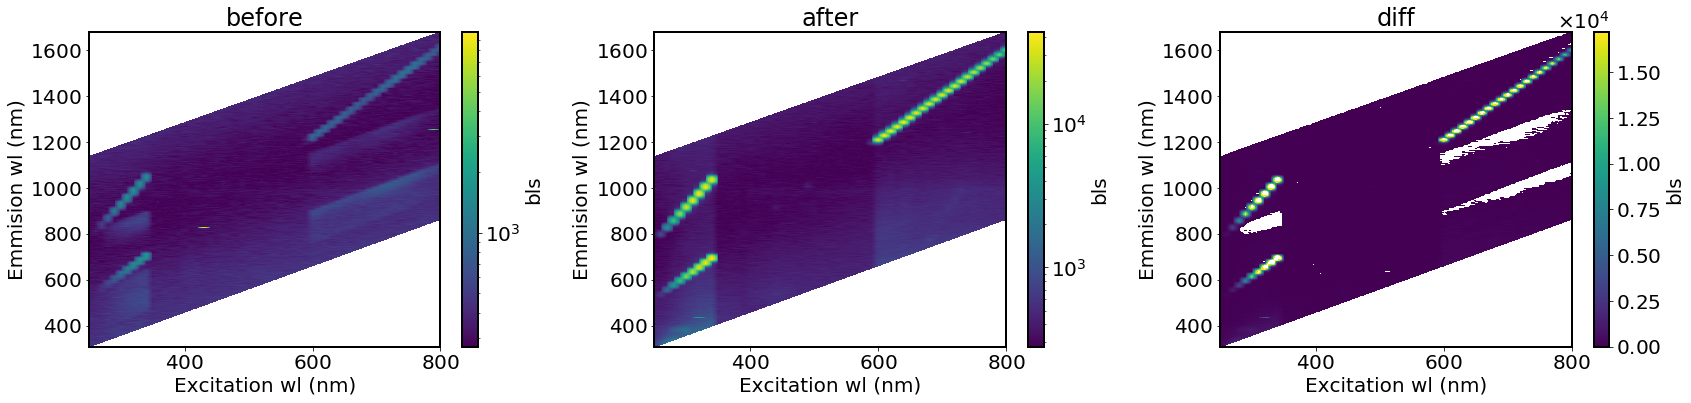

In [54]:
plot_comparison_2d(lif462_before, lif462_after2, exposure=10, column="rate")

/home/gonzalo/sw/anaconda3/envs/CC/lib/python3.7/site-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


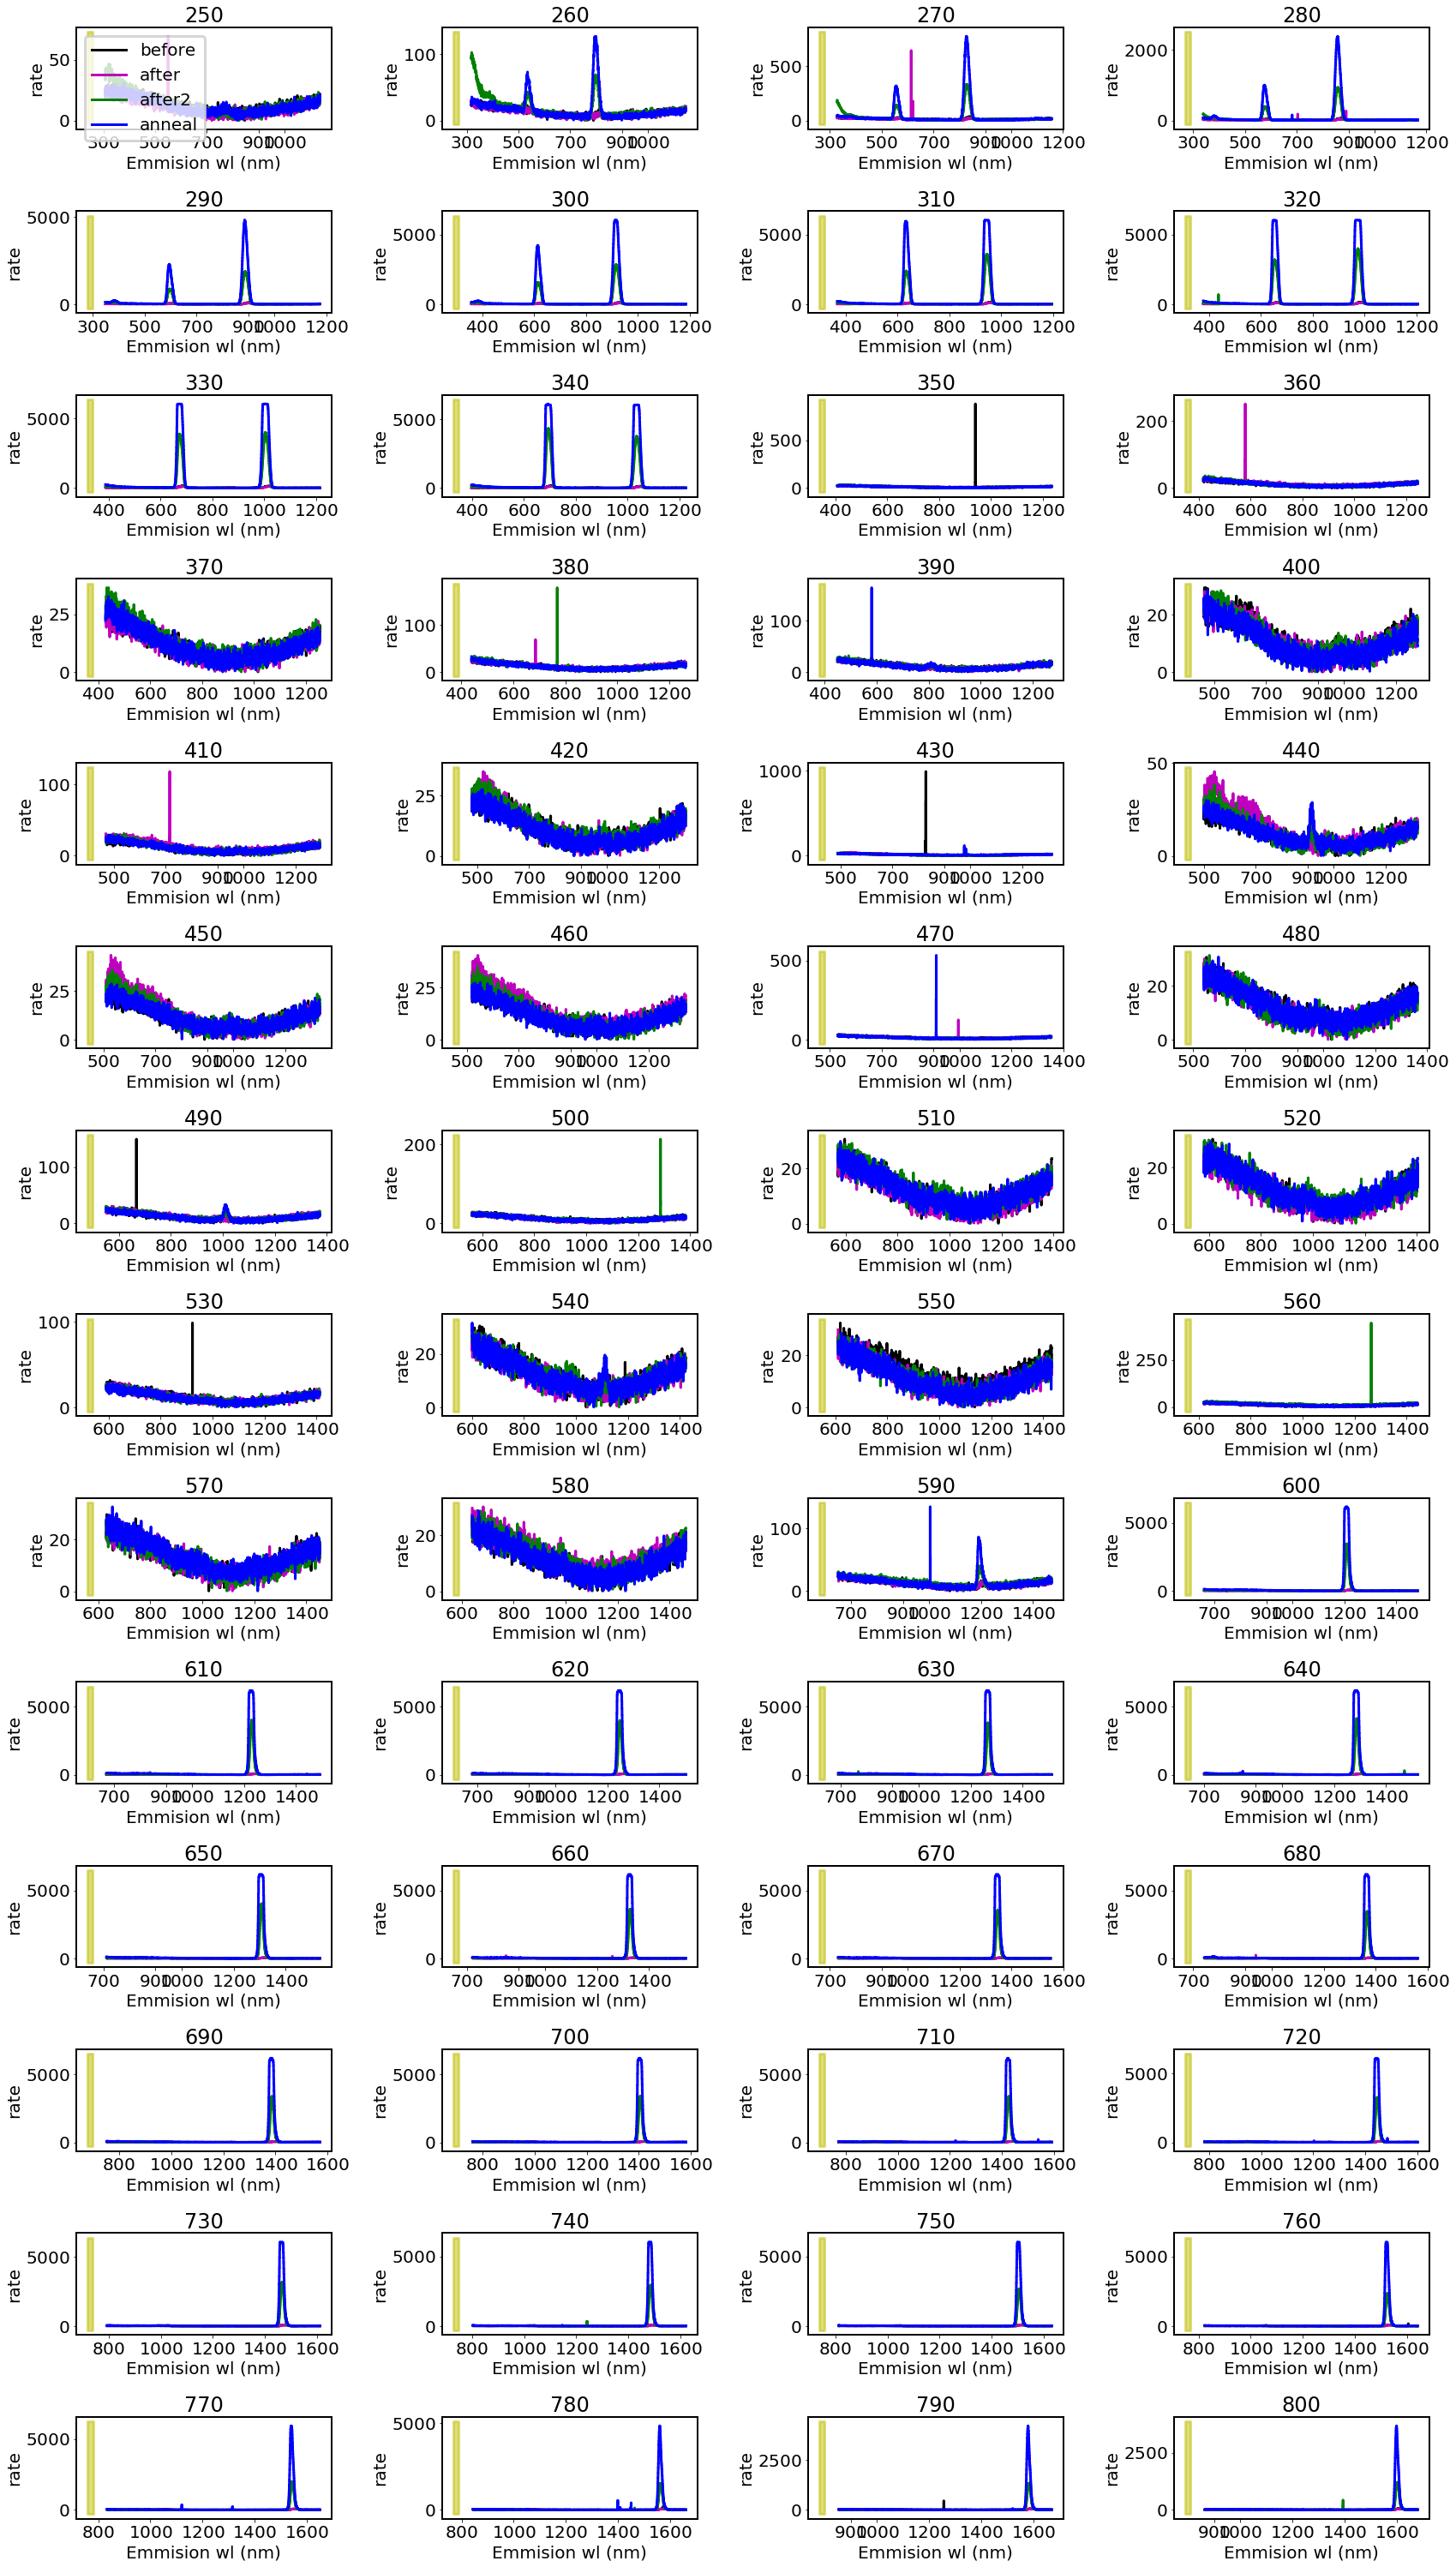

In [178]:
plot_comparison_1d_array(lif462_before, lif462_after, lif462_after2, lif462_anneal, exposure=10, column="rate", labels="before after after2 anneal".split())

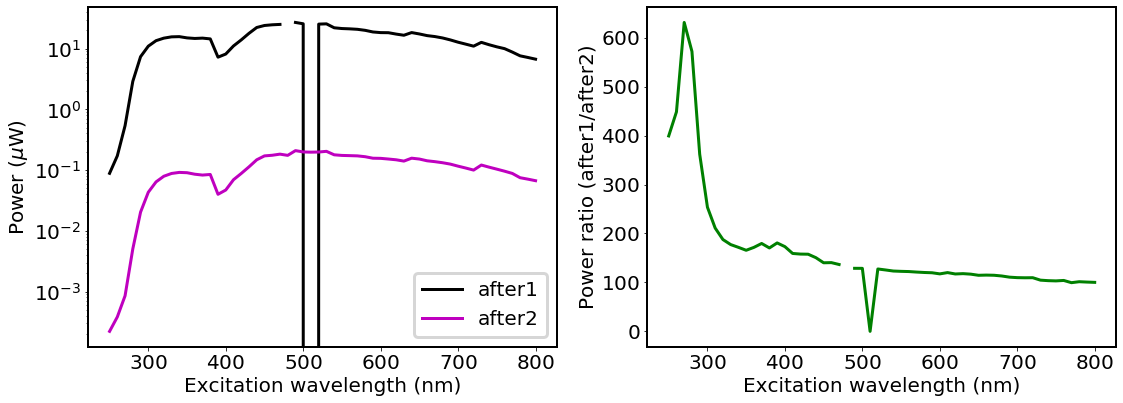

In [49]:
plot_power(lif462_after, lif462_after2, exposure=10, labels="after1 after2".split())
#plt.yscale("log")
plt.tight_layout()

# MgF

/home/gonzalo/sw/git/CC/CCcore.py:32: RuntimeWarning: invalid value encountered in greater_equal
  if low  is not None: sel &= x >= low
/home/gonzalo/sw/git/CC/CCcore.py:33: RuntimeWarning: invalid value encountered in less
  if high is not None: sel &= x <  high
/home/gonzalo/sw/anaconda3/envs/CC/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


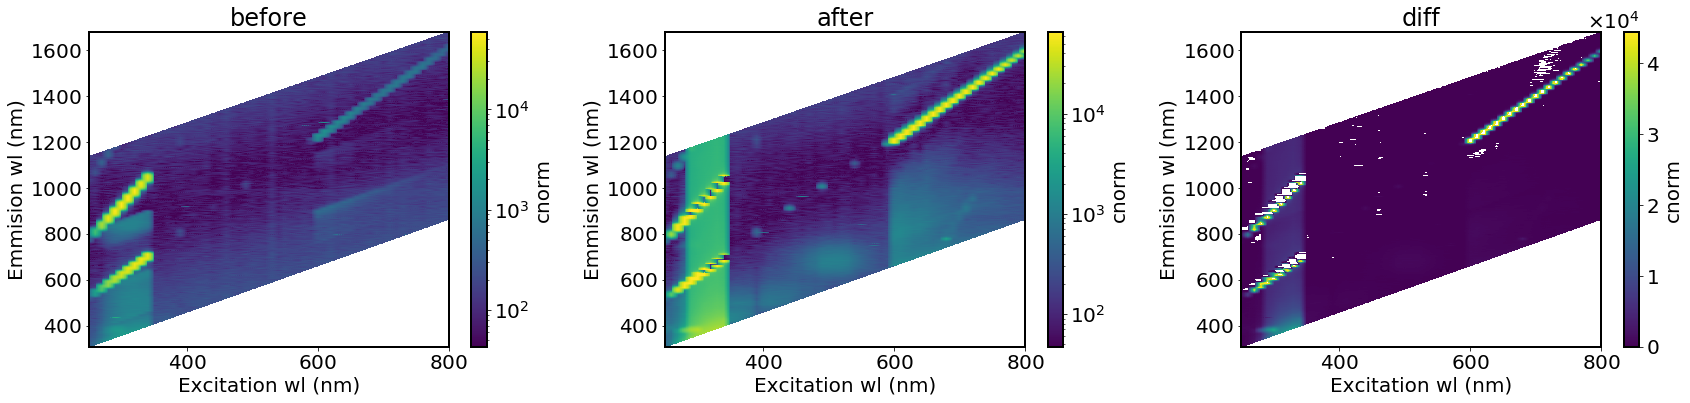

In [50]:
plot_comparison_2d(mgf482_before, mgf482_after2, exposure=10, column="cnorm")

/home/gonzalo/sw/anaconda3/envs/CC/lib/python3.7/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


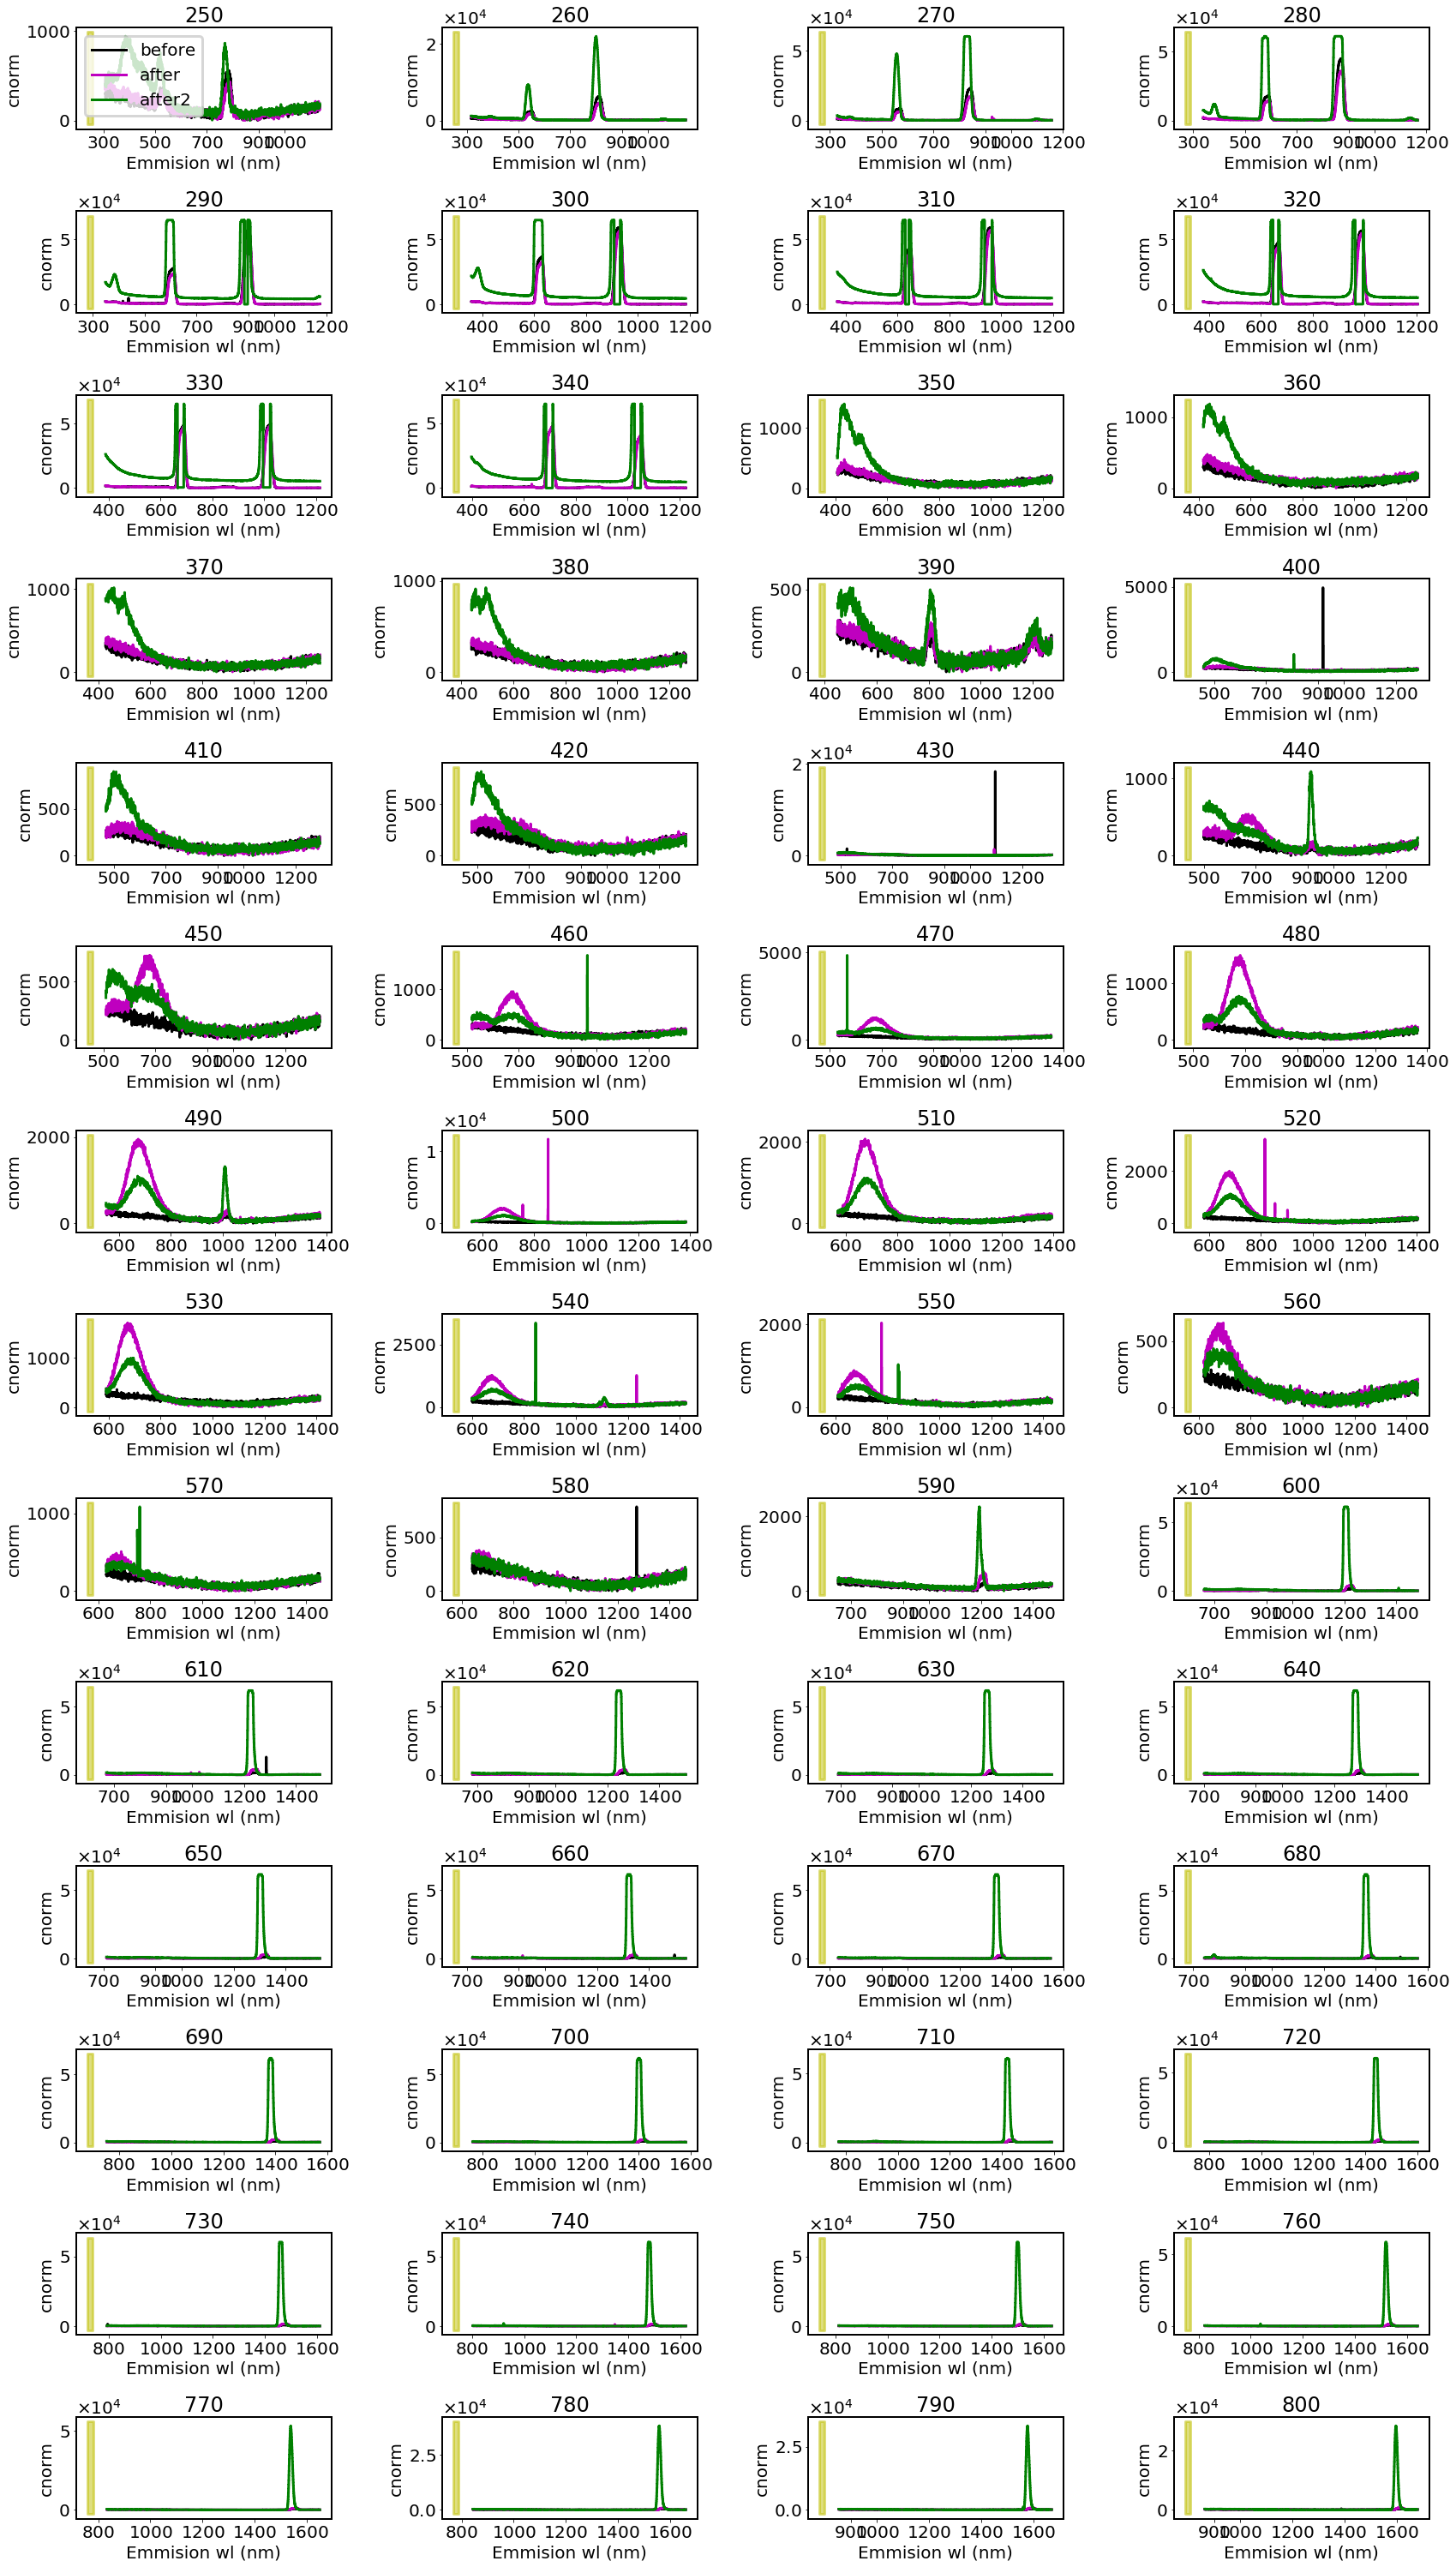

In [51]:
plot_comparison_1d_array(mgf482_before, mgf482_after, mgf482_after2,  exposure=10, column="cnorm")

# Pretty

## LiF

/home/gonzalo/sw/git/CC/CCcore.py:32: RuntimeWarning: invalid value encountered in greater_equal
  if low  is not None: sel &= x >= low
/home/gonzalo/sw/git/CC/CCcore.py:33: RuntimeWarning: invalid value encountered in less
  if high is not None: sel &= x <  high


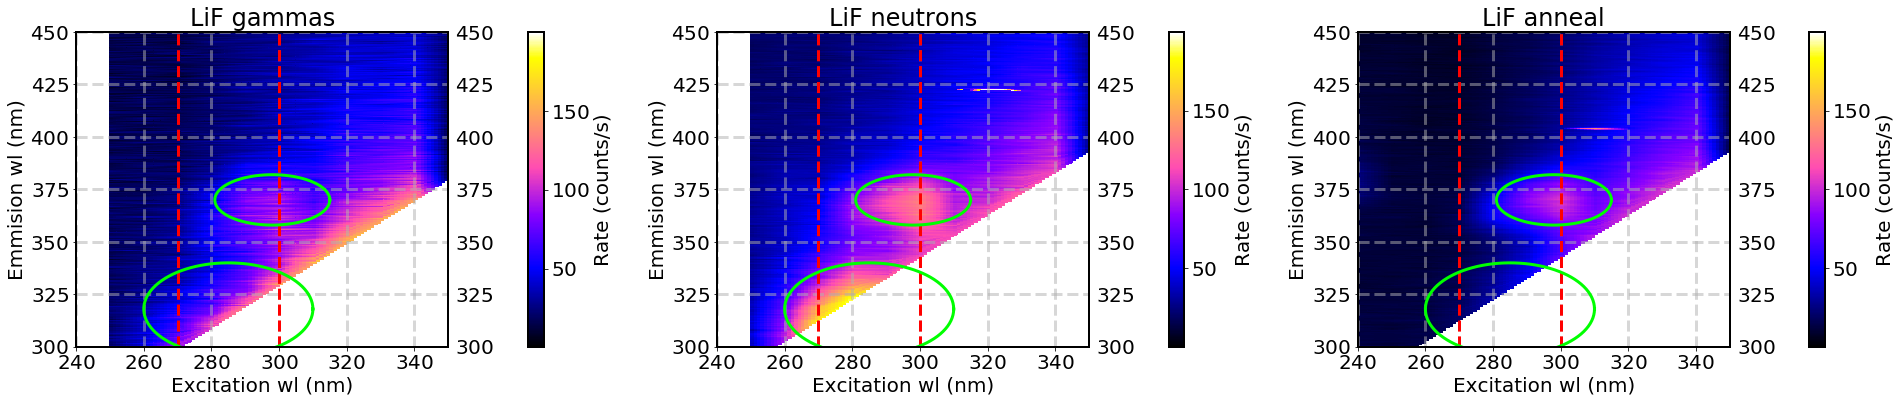

In [16]:
plt.figure(figsize=(9*3, 6))
k=0
for when, lif in dict(gammas=lif460_gamma, neutrons=lif462_after2, anneal=lif462_24h).items():
    plt.subplot(1, 3, k+1);k+=1
    df = filter_df(lif, exposure=10)
    df = remove_duplicate_grating(df)
    f  = 1 if when == "neutrons" else 2 if when == "anneal" else 0.3
    s, c = plot2d(df.ex_wl, df.em_wl, df.rate / f, title=f"LiF {when}"
                 , log=False
                 , zlabel="Rate (counts/s)"
                 , cmin=0
                 , cmax=2e2
                 , cmap="gnuplot2"
                 , pad = 0.15)
    
    draw_ellipse(298, 370, 17, 12, color="lime", ls="-")
    draw_ellipse(285, 318, 25, 22, color="lime", ls="-")
    plt.vlines(270, 300, 450, "r", ls="--")
    plt.vlines(300, 300, 450, "r", ls="--")
    plt.xlim(240, 350)
    plt.ylim(300, 450)
    plt.grid()
    plt.tick_params(labelright=True)
    
plt.tight_layout()
plt.savefig("/home/gonzalo/Escritorio/lif_2d_uv.png")

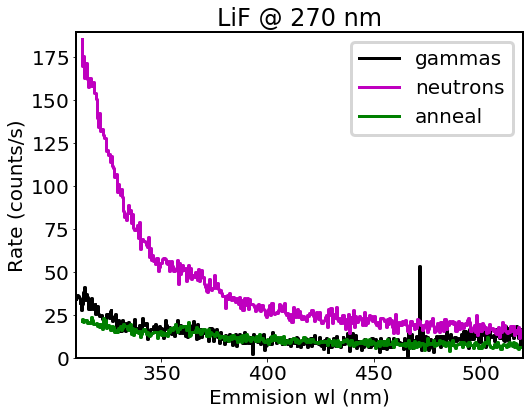

In [33]:
ex_wl    = 270
exposure = 10

for when, lif in dict(gammas=lif460_gamma, neutrons=lif462_after2, anneal=lif462_24h).items():
    df = filter_df(lif, exposure=exposure, ex_wl=ex_wl)
    df = remove_duplicate_grating(df)
    df = rebin_df(df, 1)
    f  = 1 if when == "neutrons" else 1.9 if when == "anneal" else 0.55
#    s  = 5 if when == ""
    plot1d(df.em_wl, df.rate / f
          , title = f"LiF @ {ex_wl} nm"
          , label = when
          , ylabel = "Rate (counts/s)"
          )

plt.legend()
plt.xlim(310, 520)
plt.ylim(  0, 190)
    
plt.savefig("/home/gonzalo/Escritorio/lif_270_330.png")

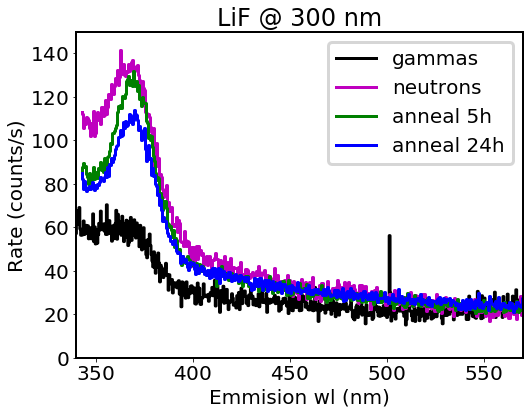

In [96]:
ex_wl    = 300
exposure = 10

for when, lif in dict(gammas=lif460_gamma, neutrons=lif462_after2, anneal5h=lif462_anneal, anneal24h=lif462_24h).items():
    df = filter_df(lif, exposure=exposure, ex_wl=ex_wl)
    df = remove_duplicate_grating(df)
    df = rebin_df(df, 1)
#    f  = 1
    f  = 1 if when == "neutrons" else 2.1 if when == "anneal5h" else 2.1 if when == "anneal24h" else 0.55
    s  = 25 if when == "anneal24h" else 20 if when == "anneal5h" else 5 if when == "gammas" else 0
    plot1d(df.em_wl, (df.rate + s) / f
          , title = f"LiF @ {ex_wl} nm"
          , label = when[:6] + " "  + when[6:] if "h" in when else when
          , ylabel = "Rate (counts/s)"
          )

plt.legend()
plt.xlim(340, 570)
plt.ylim(  0, 150)
    
plt.savefig("/home/gonzalo/Escritorio/lif_300_380.png")

## MgF

/home/gonzalo/sw/anaconda3/envs/CC/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


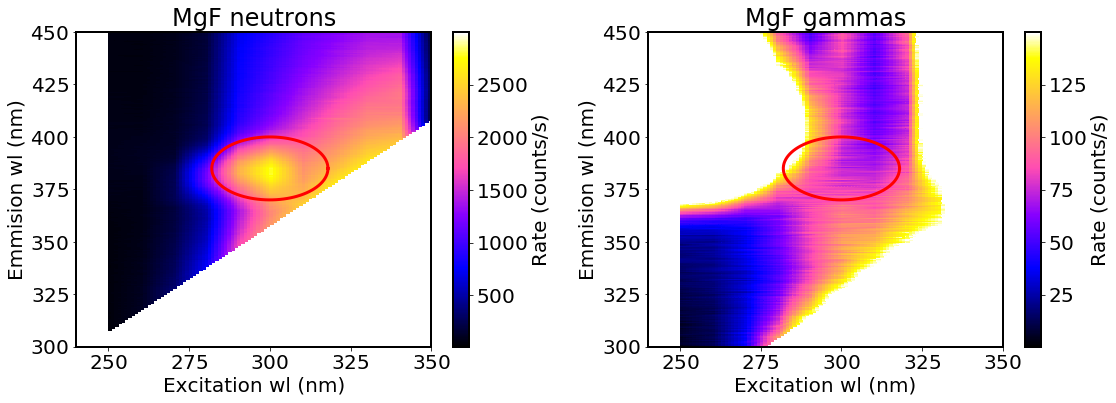

In [147]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
df = filter_df(mgf482_after2, exposure=10)
df = remove_duplicate_grating(df)
s, c = plot2d(df.ex_wl, df.em_wl, df.rate, title="MgF neutrons"
             , log=False
             , zlabel="Rate (counts/s)"
             , cmin=1e1
             , cmax=3e3
             , cmap="gnuplot2"
             )
#plt.vlines(250, 300, 450, "r", ls="--")
#plt.vlines(290, 300, 450, "r", ls="--")
plt.xlim(240, 350)
plt.ylim(300, 450)

plt.subplot(1, 2, 2)
df = filter_df(mgf480_gamma, exposure=10)
df = remove_duplicate_grating(df)
s, c = plot2d(df.ex_wl, df.em_wl, df.rate, title="MgF gammas"
             , log=False
             , zlabel="Rate (counts/s)"
#             , cmin=1e1
             , cmax=150
             , cmap="gnuplot2"
             )
#plt.vlines(250, 300, 450, "r", ls="--")
#plt.vlines(290, 300, 450, "r", ls="--")
plt.xlim(240, 350)
plt.ylim(300, 450)

for i in range(1, 3):
    plt.subplot(1, 2, i)
    u, v, a, v = 300, 385, 18, 15

    t = np.linspace(0, 2*np.pi, 100)
    plt.plot( u + a*np.cos(t)
            , v + b*np.sin(t)
            , "r-")

#plt.arrow()

plt.tight_layout()
plt.savefig("/home/gonzalo/Escritorio/mgf_neutron_gamma_comparison.png")

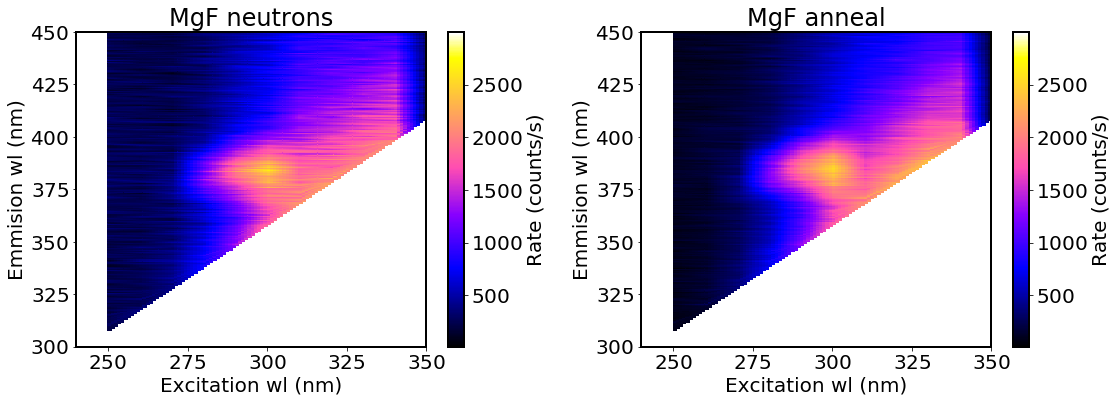

In [213]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
df = filter_df(mgf482_after2, exposure=.2)
df = remove_duplicate_grating(df)
s, c = plot2d(df.ex_wl, df.em_wl, df.rate, title="MgF neutrons"
             , log=False
             , zlabel="Rate (counts/s)"
             , cmin=1e1
             , cmax=3e3
             , cmap="gnuplot2"
             )

plt.xlim(240, 350)
plt.ylim(300, 450)

plt.subplot(1, 2, 2)
df = filter_df(mgf482_anneal, exposure=.2)
df = remove_duplicate_grating(df)
s, c = plot2d(df.ex_wl, df.em_wl, df.rate/2, title="MgF anneal"
             , log=False
             , zlabel="Rate (counts/s)"
             , cmin=1e1
             , cmax=3e3
             , cmap="gnuplot2"
             )

plt.xlim(240, 350)
plt.ylim(300, 450)


plt.tight_layout()

/home/gonzalo/sw/git/CC/CCcore.py:32: RuntimeWarning: invalid value encountered in greater_equal
  if low  is not None: sel &= x >= low
/home/gonzalo/sw/git/CC/CCcore.py:33: RuntimeWarning: invalid value encountered in less
  if high is not None: sel &= x <  high


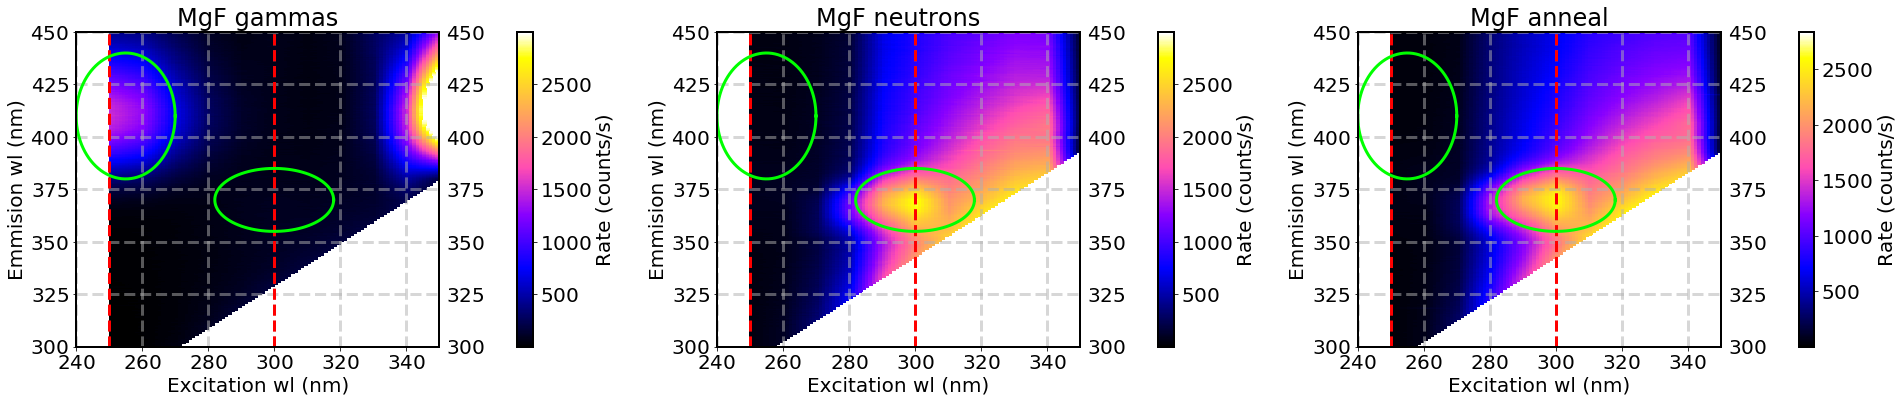

In [98]:
plt.figure(figsize=(9*3, 6))
k=0
for when, lif in dict(gammas=mgf480_gamma, neutrons=mgf482_after2, anneal=mgf482_anneal).items():
    plt.subplot(1, 3, k+1);k+=1
    df = filter_df(lif, exposure=10)
    df = remove_duplicate_grating(df)
    f  = 1 if when == "neutrons" else 2.3 if when == "anneal" else 1#0.3
    s, c = plot2d(df.ex_wl, df.em_wl, df.rate / f, title=f"MgF {when}"
                 , log=False
                 , zlabel="Rate (counts/s)"
                 , cmin=1e0
                 , cmax=3e3
                 , cmap="gnuplot2"
                 , pad =0.15)
    
    draw_ellipse(255, 410, 15, 30, color="lime", ls="-")
    draw_ellipse(300, 370, 18, 15, color="lime", ls="-")
    plt.vlines(250, 300, 450, "r", ls="--")
    plt.vlines(300, 300, 450, "r", ls="--")
    plt.xlim(240, 350)
    plt.ylim(300, 450)
    plt.grid()
    plt.tick_params(labelright=True)

plt.tight_layout()
plt.savefig("/home/gonzalo/Escritorio/mgf_2d_uv.png")

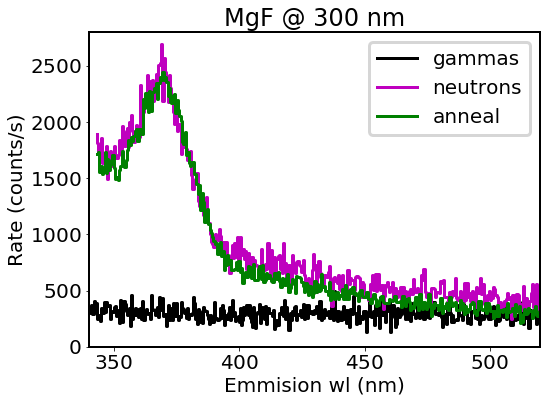

In [127]:
ex_wl    = 300
exposure = .2

for when, lif in dict(gammas=mgf480_gamma, neutrons=mgf482_after2, anneal=mgf482_anneal).items():
    df = filter_df(lif, exposure=exposure, ex_wl=ex_wl)
    df = remove_duplicate_grating(df)
    df = rebin_df(df, 1)
    f  = 1
    f  = 1 if when == "neutrons" else 2.1 if when == "anneal" else 1#0.032
    s  = 0#-280 if when == "gammas" else 0
    plot1d(df.em_wl, (df.rate + s) / f
          , title = f"MgF @ {ex_wl} nm"
          , label = when
          , ylabel = "Rate (counts/s)"
          )

plt.legend()
#plt.xlim(850, 950)
plt.xlim(340, 520)
plt.ylim(  0, 2800)

plt.tight_layout()
plt.savefig("/home/gonzalo/Escritorio/mgf_300_370.png")

TransformedBbox(
    Bbox(x0=0.0, y0=0.0, x1=8.0, y1=6.0),
    Affine2D(
        [[72.  0.  0.]
         [ 0. 72.  0.]
         [ 0.  0.  1.]]))


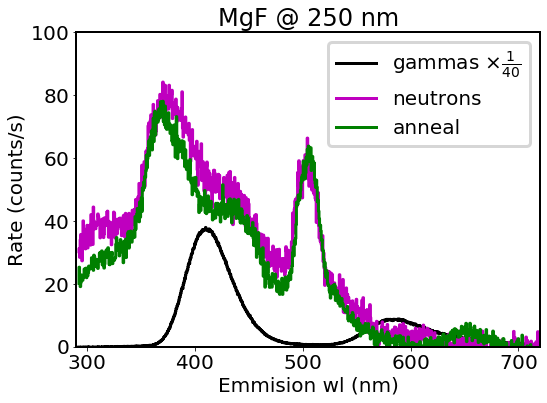

In [128]:
ex_wl    = 250
exposure = 10

for when, lif in dict(gammas=mgf480_gamma, neutrons=mgf482_after2, anneal=mgf482_anneal).items():
    df = filter_df(lif, exposure=exposure, ex_wl=ex_wl)
    df = remove_duplicate_grating(df)
    df = rebin_df(df, 1)
    f  = 1
    f  = 1 if when == "neutrons" else 1.7 if when == "anneal" else 40
    s  = -10#-5 if when == "anneal" else 0
    x  = 0#5 if when == "anneal" else 0
    plot1d(df.em_wl - x, (df.rate + s) / f
          , title = f"MgF @ {ex_wl} nm"
          , label = when if when != "gammas" else "gammas $\\times \\frac{1}{40}$"
          , ylabel = "Rate (counts/s)"
          )

plt.legend()
#plt.xlim(850, 950)
plt.xlim(290, 720)
plt.ylim(  0, 100)

print(plt.gcf().get_window_extent())
plt.tight_layout()

plt.savefig("/home/gonzalo/Escritorio/mgf_250_400.png")

(290, 520)

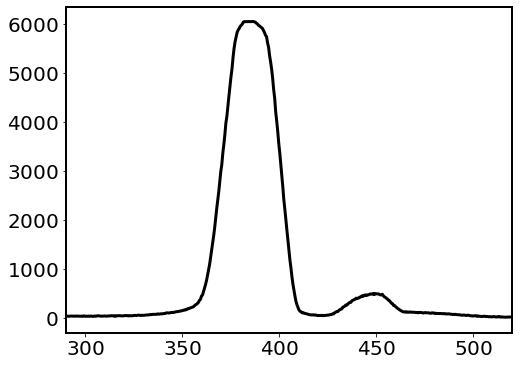

In [80]:
df = filter_df(mgf482_24h, exposure=10, ex_wl=220)
plt.plot(df.em_wl, df.rate)
plt.xlim(290, 520)

(300, 520)

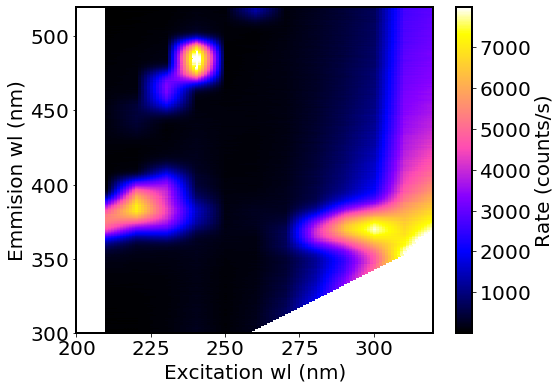

In [63]:
df = filter_df(mgf482_24h, exposure=2)
plot2d(df.ex_wl, df.em_wl, df.rate
      , log=False
      , zlabel="Rate (counts/s)"
      , cmin=1e0
      , cmax=8e3
      , cmap="gnuplot2")

plt.xlim(200, 320)
plt.ylim(300, 520)

(300, 520)

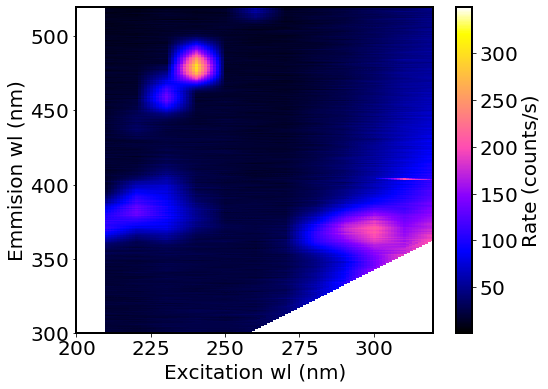

In [74]:
df = filter_df(lif462_24h, exposure=10)
plot2d(df.ex_wl, df.em_wl, df.rate
      , log=False
      , zlabel="Rate (counts/s)"
      , cmin=1e0
      , cmax=350
      , cmap="gnuplot2")

plt.xlim(200, 320)
plt.ylim(300, 520)

(250, 520)

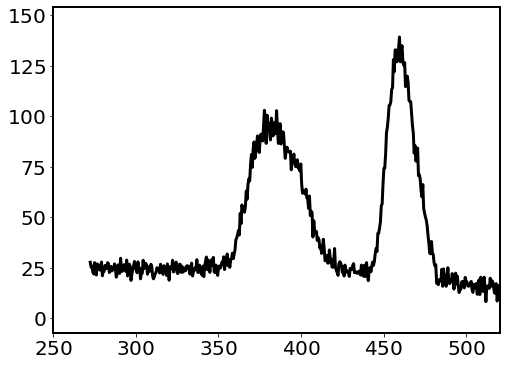

In [78]:
df = filter_df(lif462_24h, exposure=10, ex_wl=230)
plt.plot(df.em_wl, df.rate)
plt.xlim(250, 520)